# Metadata

```yaml
Course:   DS 5001
Module:   04 Lab
Topic:    NLTK Parsers
Author:   R.C. Alvarado
Date:     5 February 2022 (revised)
```

**Purpose**:  Demonstrate use of NLTK's sentence and token parsers.

# Set Up

## Config

In [62]:
data_home = "../data"
src_file = f"{data_home}/gutenberg/pg161.txt"
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import re

In [64]:
np.__version__

'1.23.4'

In [65]:
import scipy as sp
sp.__version__

'1.7.3'

# Import file into a dataframe

We import our text from scratch in order to demonstrate the use of NLTKs model-driven parsers. 

In [66]:
LINES = pd.DataFrame(open(src_file, 'r', encoding='utf-8-sig').readlines(), columns=['line_str'])
LINES.index.name = 'line_num'
LINES.line_str = LINES.line_str.str.replace(r'\n+', ' ', regex=True).str.strip()

In [67]:
LINES.sample(20)

,line_str
line_num,
9624,"""I must hurry away then, to give him those tha..."
5111,
7140,"wrong in the other, she thought herself at lib..."
8983,sometimes I do not know which way to look befo...
11277,
7550,"and is grown quite thin. Is she ill?"""
844,"much beloved. ""Dear, dear Norland!"" said Mari..."
10003,
6498,"very pretty canal; and every thing, in short, ..."


# Clip Cruft

In [68]:
clip_pats = [
    r"^\(1811\)", 
    r"^THE END"
]

line_a = 0
line_b = len(LINES)
try:
    pat_a = LINES.line_str.str.match(clip_pats[0])
    line_a = LINES.loc[pat_a].index[0] + 1
except:
    print("pat_a not found")

try:
    pat_b = LINES.line_str.str.match(clip_pats[1])
    line_b = LINES.loc[pat_b].index[0] - 1
except:
    print("pat_b not found")

LINES = LINES.loc[line_a : line_b]

In [69]:
LINES.head()

,line_str
line_num,
38,
39,
40,
41,
42,CHAPTER 1


In [70]:
LINES.tail()

,line_str
line_num,
12650,"within sight of each other, they could live wi..."
12651,"between themselves, or producing coolness betw..."
12652,
12653,
12654,


# Chunk Chapters

In [71]:
chap_pat = r"^\s*(CHAPTER)\s+\d+"
chap_lines = LINES.line_str.str.match(chap_pat, case=False)
LINES.loc[chap_lines, 'chap_num'] = [i+1 for i in range(LINES.loc[chap_lines].shape[0])]
LINES.chap_num = LINES.chap_num.ffill()
LINES = LINES.dropna(subset=['chap_num']) # Remove everything before Chapter 1
LINES = LINES.loc[~chap_lines] # Remove chapter heading lines; their work is done
LINES.chap_num = LINES.chap_num.astype('int') # Convert chap_num from float to int

In [72]:
CHAPS = LINES.groupby(OHCO[:1]).line_str\
    .apply(lambda x: '\n'.join(x))\
    .str.strip()\
    .to_frame('chap_str')

In [73]:
CHAPS.head()

,chap_str
chap_num,
1,The family of Dashwood had long been settled i...
2,Mrs. John Dashwood now installed herself mistr...
3,Mrs. Dashwood remained at Norland several mont...
4,"""What a pity it is, Elinor,"" said Marianne, ""t..."
5,"No sooner was her answer dispatched, than Mrs...."


# Chunk Paragraphs

In [74]:
para_pat = r'\n\n+'
PARAS = CHAPS['chap_str'].str.split(para_pat, expand=True).stack()\
    .to_frame('para_str').sort_index()
PARAS.index.names = OHCO[:2]
PARAS['para_str'] = PARAS['para_str'].str.replace(r'\n', ' ', regex=True)
PARAS['para_str'] = PARAS['para_str'].str.strip()
PARAS = PARAS[~PARAS['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs

In [75]:
PARAS.head()

para_str
chap_num para_num                                                   
1        0         The family of Dashwood had long been settled i...
         1         By a former marriage, Mr. Henry Dashwood had o...
         2         The old gentleman died: his will was read, and...
         3         Mr. Dashwood's disappointment was, at first, s...
         4         His son was sent for as soon as his danger was...

# Use NLTK to Chunk Sentences and Parse Tokens

## Import NLTK and download resources

If you need to install NLTK, see the [instructions here](https://www.nltk.org/install.html). You can also install this with Anaconda, like so:

`conda install nltk` or `conda install -c anaconda nltk` (See https://anaconda.org/anaconda/nltk)

Once you have installed NLTK, you will need to download resources, which will happen when you run the following cell. If the interactive window opens, you may need to set your NLTK Data Directory, as described in the [instructions here](https://www.nltk.org/data.html). To set the directory, click on the File menu and select Change Download Directory. For central installation, set this to `C:\nltk_data` (Windows),`/usr/local/share/nltk_data` (Mac), or `/usr/share/nltk_data` (Unix). 

> If you did not install the data to one of the above central locations, you will need to set the NLTK_DATA environment variable to specify the location of the data. (On a Windows machine, right click on “My Computer” then select Properties > Advanced > Environment Variables > User Variables > New...)

In [76]:
nltk_resources = [
    'tokenizers/punkt', 
    'taggers/averaged_perceptron_tagger', 
    'corpora/stopwords', 
    'help/tagsets'
]

In [77]:
for rsc in nltk_resources:
    try:
        nltk.data.find(rsc)
    except IndexError:
        nltk.download(rsc)

## Demonstrate `nltk.sent_tokenize()`

In [78]:
sample_para = PARAS.iloc[1].para_str

In [79]:
sample_para

"By a former marriage, Mr. Henry Dashwood had one son: by his present lady, three daughters.  The son, a steady respectable young man, was amply provided for by the fortune of his mother, which had been large, and half of which devolved on him on his coming of age.  By his own marriage, likewise, which happened soon afterwards, he added to his wealth.  To him therefore the succession to the Norland estate was not so really important as to his sisters; for their fortune, independent of what might arise to them from their father's inheriting that property, could be but small.  Their mother had nothing, and their father only seven thousand pounds in his own disposal; for the remaining moiety of his first wife's fortune was also secured to her child, and he had only a life-interest in it."

In [80]:
nltk.sent_tokenize(sample_para)

['By a former marriage, Mr. Henry Dashwood had one son: by his present lady, three daughters.',
 'The son, a steady respectable young man, was amply provided for by the fortune of his mother, which had been large, and half of which devolved on him on his coming of age.',
 'By his own marriage, likewise, which happened soon afterwards, he added to his wealth.',
 "To him therefore the succession to the Norland estate was not so really important as to his sisters; for their fortune, independent of what might arise to them from their father's inheriting that property, could be but small.",
 "Their mother had nothing, and their father only seven thousand pounds in his own disposal; for the remaining moiety of his first wife's fortune was also secured to her child, and he had only a life-interest in it."]

## Apply to `PARAS` dataframe

In [81]:
SENTS = PARAS.para_str.apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame('sent_str')
SENTS.index.names = OHCO[:3]

In [82]:
SENTS

sent_str
chap_num para_num sent_num                                                   
1        0        0         The family of Dashwood had long been settled i...
                  1         Their estate was large, and their residence wa...
                  2         The late owner of this estate was a single man...
                  3         But her death, which happened ten years before...
                  4         In the society of his nephew and niece, and th...
...                                                                       ...
50       17       3         He lived to exert, and frequently to enjoy him...
                  4         His wife was not always out of humour, nor his...
         18       0         For Marianne, however--in spite of his incivil...
         19       0         Mrs. Dashwood was prudent enough to remain at ...
         20       0         Between Barton and Delaford, there was that co...

[4947 rows x 1 columns]

## Demonstrate `nltk.word_tokenize()`

In [83]:
sample_sent = SENTS.iloc[3].sent_str

In [84]:
sample_sent

'But her death, which happened ten years before his own, produced a great alteration in his home; for to supply her loss, he invited and received into his house the family of his nephew Mr. Henry Dashwood, the legal inheritor of the Norland estate, and the person to whom he intended to bequeath it.'

In [85]:
sample_tokens = nltk.word_tokenize(sample_sent)

In [86]:
print(sample_tokens)

['But', 'her', 'death', ',', 'which', 'happened', 'ten', 'years', 'before', 'his', 'own', ',', 'produced', 'a', 'great', 'alteration', 'in', 'his', 'home', ';', 'for', 'to', 'supply', 'her', 'loss', ',', 'he', 'invited', 'and', 'received', 'into', 'his', 'house', 'the', 'family', 'of', 'his', 'nephew', 'Mr.', 'Henry', 'Dashwood', ',', 'the', 'legal', 'inheritor', 'of', 'the', 'Norland', 'estate', ',', 'and', 'the', 'person', 'to', 'whom', 'he', 'intended', 'to', 'bequeath', 'it', '.']


## Demostrate POS tagging

In [87]:
sample_tagged_tokens = nltk.pos_tag(nltk.word_tokenize(sample_sent))

In [88]:
print(sample_tagged_tokens)

[('But', 'CC'), ('her', 'PRP$'), ('death', 'NN'), (',', ','), ('which', 'WDT'), ('happened', 'VBD'), ('ten', 'CD'), ('years', 'NNS'), ('before', 'IN'), ('his', 'PRP$'), ('own', 'JJ'), (',', ','), ('produced', 'VBD'), ('a', 'DT'), ('great', 'JJ'), ('alteration', 'NN'), ('in', 'IN'), ('his', 'PRP$'), ('home', 'NN'), (';', ':'), ('for', 'IN'), ('to', 'TO'), ('supply', 'VB'), ('her', 'PRP$'), ('loss', 'NN'), (',', ','), ('he', 'PRP'), ('invited', 'VBD'), ('and', 'CC'), ('received', 'VBD'), ('into', 'IN'), ('his', 'PRP$'), ('house', 'NN'), ('the', 'DT'), ('family', 'NN'), ('of', 'IN'), ('his', 'PRP$'), ('nephew', 'JJ'), ('Mr.', 'NNP'), ('Henry', 'NNP'), ('Dashwood', 'NNP'), (',', ','), ('the', 'DT'), ('legal', 'JJ'), ('inheritor', 'NN'), ('of', 'IN'), ('the', 'DT'), ('Norland', 'NNP'), ('estate', 'NN'), (',', ','), ('and', 'CC'), ('the', 'DT'), ('person', 'NN'), ('to', 'TO'), ('whom', 'WP'), ('he', 'PRP'), ('intended', 'VBD'), ('to', 'TO'), ('bequeath', 'VB'), ('it', 'PRP'), ('.', '.')]


## Apply to `SENTS` dataframe

In [89]:
keep_whitespace = True

In [90]:
if keep_whitespace:
    TOKENS = SENTS.sent_str\
            .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
            .stack()\
            .to_frame('pos_tuple')
else:
    TOKENS = SENTS.sent_str\
            .apply(lambda x: pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x))))\
            .stack()\
            .to_frame('pos_tuple')

In [91]:
TOKENS.index.names = OHCO

In [92]:
TOKENS

pos_tuple
chap_num para_num sent_num token_num                 
1        0        0        0                (The, DT)
                           1             (family, NN)
                           2                 (of, IN)
                           3          (Dashwood, NNP)
                           4               (had, VBD)
...                                               ...
50       20       0        64          (coolness, NN)
                           65           (between, IN)
                           66           (their, PRP$)
                           67         (husbands, NNS)
                           68                  (., .)

[141320 rows x 1 columns]

In [93]:
TOKENS['pos'] = TOKENS.pos_tuple.apply(lambda x: x[1])
TOKENS['token_str'] = TOKENS.pos_tuple.apply(lambda x: x[0])
TOKENS['term_str'] = TOKENS.token_str.str.lower()

In [94]:
TOKENS

pos_tuple   pos token_str  \
chap_num para_num sent_num token_num                                    
1        0        0        0                (The, DT)    DT       The   
                           1             (family, NN)    NN    family   
                           2                 (of, IN)    IN        of   
                           3          (Dashwood, NNP)   NNP  Dashwood   
                           4               (had, VBD)   VBD       had   
...                                               ...   ...       ...   
50       20       0        64          (coolness, NN)    NN  coolness   
                           65           (between, IN)    IN   between   
                           66           (their, PRP$)  PRP$     their   
                           67         (husbands, NNS)   NNS  husbands   
                           68                  (., .)     .         .   

                                      term_str  
chap_num para_num sent_num token_num            
1        0        0        0               the  
                           1            family  
                           2                of  
                           3          dashwood  
                           4               had  
...                                        ...  
50       20       0        64         coolness  
                           65          between  
                           66            their  
                           67         husbands  
                           68                .  

[141320 rows x 4 columns]

# Use NLTK to annotate TOKENS and VOCAB

## Extract VOCAB

In [130]:
VOCAB = TOKENS.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['n_chars'] = VOCAB.index.str.len()

In [131]:
VOCAB

,n,p,i,n_chars
term_str,,,,
",",9900,0.070054,3.835393,1
the,4101,0.029019,5.106846,3
to,4101,0.029019,5.106846,2
.,4028,0.028503,5.132758,1
of,3571,0.025269,5.306494,2
...,...,...,...,...
festival,1,0.000007,17.108606,8
proclaim,1,0.000007,17.108606,8
spending,1,0.000007,17.108606,8


## Add Max POS

In [132]:
TOKENS[['term_str','pos']].value_counts().sort_index().loc['love']

pos
IN      1
NN     47
VB     18
VBP    10
dtype: int64

In [133]:
VOCAB['max_pos'] = TOKENS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)

In [134]:
VOCAB

,n,p,i,n_chars,max_pos
term_str,,,,,
",",9900,0.070054,3.835393,1,","
the,4101,0.029019,5.106846,3,DT
to,4101,0.029019,5.106846,2,TO
.,4028,0.028503,5.132758,1,.
of,3571,0.025269,5.306494,2,IN
...,...,...,...,...,...
festival,1,0.000007,17.108606,8,NN
proclaim,1,0.000007,17.108606,8,VB
spending,1,0.000007,17.108606,8,VBG


## The U Penn Tree Bank

## Extract POS

**Grab UPenn Codes**

We get a text version of the UPenn Codes, or tag set, by calling `nltk.help.upenn_tagset()`. There is a script in `data/misc` that will generate this file for you, although a copy of it has already been generated. We use this to add a definition column to our table. This can be used later in visualizations, etc.

In [135]:
tags_csv = [(line.split()[0], ' '.join(line.split()[1:])) 
            for line in open(f'{data_home}/misc/upenn_tagset.txt', 'r').readlines()]

In [136]:
TOKENS

pos_tuple   pos token_str  \
chap_num para_num sent_num token_num                                    
1        0        0        0                (The, DT)    DT       The   
                           1             (family, NN)    NN    family   
                           2                 (of, IN)    IN        of   
                           3          (Dashwood, NNP)   NNP  Dashwood   
                           4               (had, VBD)   VBD       had   
...                                               ...   ...       ...   
50       20       0        64          (coolness, NN)    NN  coolness   
                           65           (between, IN)    IN   between   
                           66           (their, PRP$)  PRP$     their   
                           67         (husbands, NNS)   NNS  husbands   
                           68                  (., .)     .         .   

                                      term_str  
chap_num para_num sent_num token_num            
1        0        0        0               the  
                           1            family  
                           2                of  
                           3          dashwood  
                           4               had  
...                                        ...  
50       20       0        64         coolness  
                           65          between  
                           66            their  
                           67         husbands  
                           68                .  

[141320 rows x 4 columns]

In [137]:
POS = pd.DataFrame(tags_csv)
POS.columns = ['pos_code','pos_def']
POS = POS.set_index('pos_code')
POS['n'] = TOKENS.pos.value_counts()
POS['n'] = POS['n'].fillna(0).astype('int')
POS['group'] = POS.apply(lambda x: x.name[:2], 1)
POS['punc'] = POS.apply(lambda x: bool(re.match(r"^\W", x.name)), 1)

In [138]:
POS[POS.punc].index.to_list()

['$', "''", '(', ')', ',', '--', '.', ':', '``']

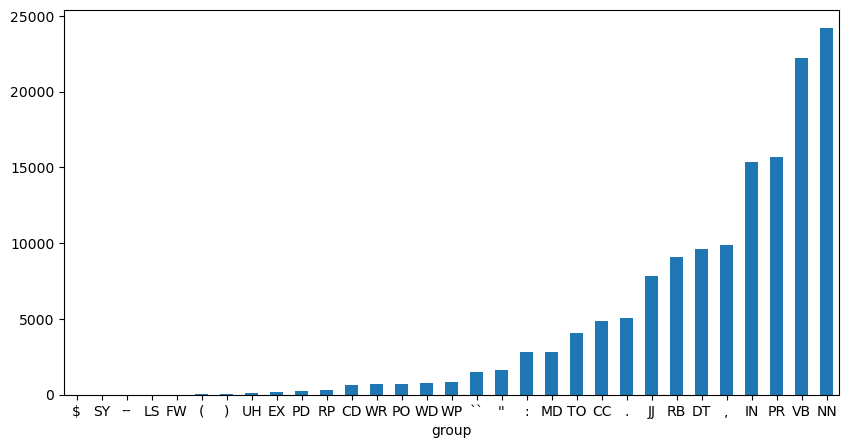

In [139]:
POS.groupby('group').n.sum().sort_values().plot.bar(figsize=(10,5), rot=0);

## Compute POS ambiguity

In [140]:
TPM = TOKENS[['term_str','pos']].value_counts().unstack()

In [141]:
VOCAB['n_pos'] = TPM.count(1)

In [142]:
VOCAB.sort_values('n_pos')

,n,p,i,n_chars,max_pos,n_pos
term_str,,,,,,
",",9900,0.070054,3.835393,1,",",1
projects,1,0.000007,17.108606,8,NNS,1
latest,1,0.000007,17.108606,6,JJS,1
favour.,1,0.000007,17.108606,7,NN,1
hating,1,0.000007,17.108606,6,VBG,1
...,...,...,...,...,...,...
round,27,0.000191,12.353719,5,NN,7
heard,78,0.000552,10.823204,5,VBN,7
half,55,0.000389,11.327246,4,PDT,7


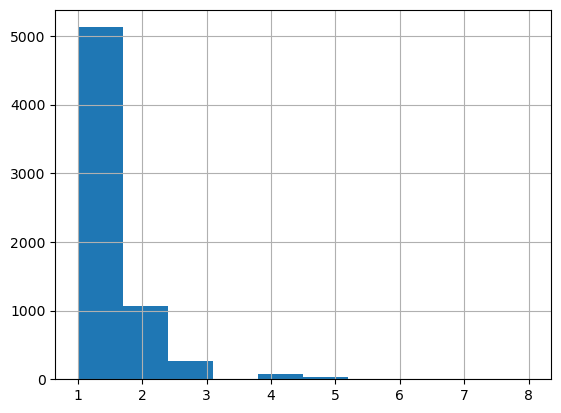

In [143]:
VOCAB.n_pos.hist();

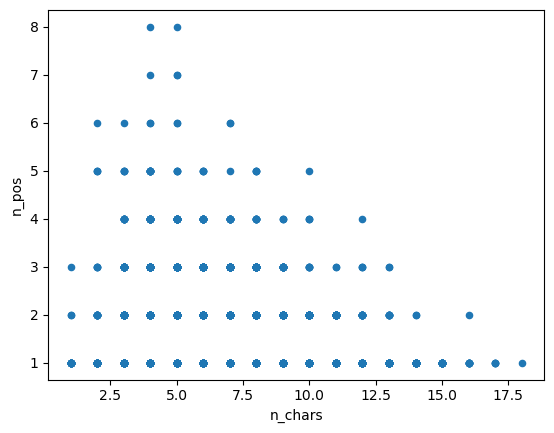

In [144]:
VOCAB.plot.scatter('n_chars', 'n_pos');

## Extract Max POS

In [145]:
VOCAB['max_pos'] = TPM.idxmax(1)

In [146]:
VOCAB

,n,p,i,n_chars,max_pos,n_pos
term_str,,,,,,
",",9900,0.070054,3.835393,1,",",1
the,4101,0.029019,5.106846,3,DT,1
to,4101,0.029019,5.106846,2,TO,1
.,4028,0.028503,5.132758,1,.,1
of,3571,0.025269,5.306494,2,IN,1
...,...,...,...,...,...,...
festival,1,0.000007,17.108606,8,NN,1
proclaim,1,0.000007,17.108606,8,VB,1
spending,1,0.000007,17.108606,8,VBG,1


## Identify Stopwords

We use NLTK's built in stopword list for English. Note that we can add and subtract from this list, or just create our own list and keep it in our data model.

In [169]:
sw = pd.DataFrame({'stop': 1}, index=nltk.corpus.stopwords.words('english'))
sw.index.name='term_str'

In [170]:
sw.head()

,stop
term_str,
i,1
me,1
my,1
myself,1
we,1


In [155]:
if 'stop' not in VOCAB.columns:
    VOCAB = VOCAB.join(sw)
    VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [157]:
VOCAB

,n,p,i,n_chars,max_pos,n_pos,stop
term_str,,,,,,,
",",9900,0.070054,3.835393,1,",",1,0
the,4101,0.029019,5.106846,3,DT,1,1
to,4101,0.029019,5.106846,2,TO,1,1
.,4028,0.028503,5.132758,1,.,1,0
of,3571,0.025269,5.306494,2,IN,1,1
...,...,...,...,...,...,...,...
festival,1,0.000007,17.108606,8,NN,1,0
proclaim,1,0.000007,17.108606,8,VB,1,0
spending,1,0.000007,17.108606,8,VBG,1,0


## Add Stems

In [167]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
VOCAB['p_stem'] = VOCAB.apply(lambda x: stemmer.stem(x.name), 1)

In [159]:
VOCAB

,n,p,i,n_chars,max_pos,n_pos,stop,p_stem
term_str,,,,,,,,
",",9900,0.070054,3.835393,1,",",1,0,","
the,4101,0.029019,5.106846,3,DT,1,1,the
to,4101,0.029019,5.106846,2,TO,1,1,to
.,4028,0.028503,5.132758,1,.,1,0,.
of,3571,0.025269,5.306494,2,IN,1,1,of
...,...,...,...,...,...,...,...,...
festival,1,0.000007,17.108606,8,NN,1,0,festiv
proclaim,1,0.000007,17.108606,8,VB,1,0,proclaim
spending,1,0.000007,17.108606,8,VBG,1,0,spend


# Summary

We took a source file and showed how to use NLTK's tools to do intelligent parsing of sentences and tokens, and then to annotate the resulting TOKENS and VOCAB tables. We also created a POS table to capture information about pos usage in the corpus.

In [160]:
VOCAB.p_stem.value_counts().head(30)

respect     10
observ       8
continu      7
affect       7
admir        7
express      7
reason       7
possess      6
attend       6
suffer       6
prefer       6
allow        6
consider     6
present      6
comfort      6
depend       6
imagin       6
accept       6
perform      6
like         6
expect       6
live         6
anticip      5
attach       5
love         5
amus         5
reflect      5
answer       5
determin     5
care         5
Name: p_stem, dtype: int64

In [161]:
VOCAB[VOCAB.p_stem == 'present']

,n,p,i,n_chars,max_pos,n_pos,stop,p_stem
term_str,,,,,,,,
present,84,0.000594,10.716289,7,JJ,2,0,present
presently,8,0.000057,14.108606,9,RB,1,0,present
presented,5,0.000035,14.786678,9,VBD,2,0,present
presentation,3,0.000021,15.523644,12,NN,1,0,present
presenting,1,0.000007,17.108606,10,VBG,1,0,present
presents,1,0.000007,17.108606,8,NNS,1,0,present


In [166]:
VOCAB.loc['present']

n                 84
p           0.000594
i          10.716289
n_chars            7
max_pos           JJ
n_pos              2
stop               0
p_stem       present
Name: present, dtype: object